# Notebook 3 - Inverse design: molecules on specification

By Vincent Blay, December 2021

In this notebook we demonstrate two approaches to the generation of new molecules with a desired property specification by leveraging MACAW embeddings. 

In the first approach we generate a single large library throughout the MACAW embedding space and then retrieve promising molecules using the `hit_finder` functions.

In the second approach we generate a series of small libraries using an evolutionary strategy using the `directed_molecular_evolution` function.

In both cases, the user is returned a list of promising SMILES molecules and their predicted property values.

In [1]:
import numpy as np
import pandas as pd
import pickle

#Needed to show molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 

import macaw
print(macaw.__version__)

from macaw import *

0.1.14


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
np.random.seed(123)

In this example we will use the RON dataset, so let us load it

In [4]:
df = pd.read_csv('./data/data_RON.csv')
smiles = df.Smiles
Y = df.RON

We will also use the RON property model, so let us load it. In this case we are generating new molecules, so we will not split the dataset

In [5]:
file = open('./results/macaw/RON_model_RVR.pickle', 'rb') 
mcw, regr = pickle.load(file)
file.close()

In [6]:
len(smiles)

194

In [7]:
mcw.transform(list(smiles))

array([[ 0.42037285,  0.06961411,  0.0838933 , ..., -0.0442504 ,
        -0.02479778, -0.00986333],
       [ 0.04410784,  0.01107567,  0.24158394, ...,  0.07641157,
         0.00242411,  0.03510653],
       [-0.07433707,  0.23414213, -0.00207759, ...,  0.03633542,
         0.20821371,  0.01867818],
       ...,
       [ 0.20423117, -0.05955342, -0.08059721, ...,  0.00245891,
        -0.08204407,  0.03756517],
       [ 0.30909945,  0.23170672,  0.15254119, ...,  0.21982397,
         0.0428042 , -0.15638203],
       [ 0.34420088,  0.26039054,  0.2446837 , ...,  0.17066445,
         0.04486746, -0.13455727]])

In [8]:
X = mcw.transform(smiles)

print(np.corrcoef(Y,regr.predict(X))[0,1])

0.9777705770632934


##  Approach 1. Molecular design by generating and screening a single large library

The library generation involves computing a noisy probability matrix from which  molecules will be drawn. Molecules will have a length of up to 20 SELFIES tokens. The method only considers robust SELFIES tokens (i.e., those for which there are state-dependent derivation rules implemented).

In [9]:
smiles_lib = library_maker(smiles, max_len=20, n_gen=200000, algorithm='position', noise_factor=0.5)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
76338 unique molecules generated.


We first embed the library molecules in the MACAW space:

In [10]:
len(smiles_lib)

76338

In [11]:
X_lib = mcw.transform(smiles_lib)

In [12]:
X_lib.shape

(76338, 15)

And then we find promising molecular designs according to the desired specification (in this example, RON=110). 

For retrieving molecules from the 20-dimensional MACAW space, we will use our custom V-distance metric (`p=0.5`). If not specified, it will use `p=1` by default (Manhattan distance).

In [13]:
spec = 110. # desired RON design specification

idx, Y_hits_pred = hit_finder(X_lib, model= regr, spec = spec, X=X, Y=Y, n_hits=5, k1=5, k2=10, p=0.5, n_rounds=2)
smiles_hits = [smiles_lib[i] for i in idx]

print(smiles_hits)
print(Y_hits_pred)

['CCC(C)C(C)(C)C', 'C=C1CCC2C(C)C12', 'C=C(OCC)P=C=O', 'CPC(=O)OCP', 'CC(C)P(C)OO']
[107.68389061 108.94371044 109.91378727 111.06105664 111.27881516]


Let us visualize the molecules:

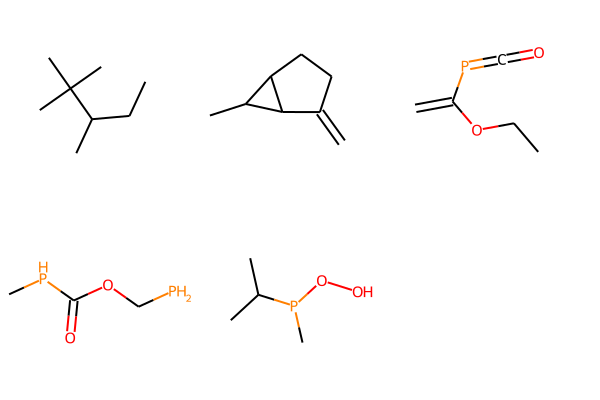

In [14]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

We can double check that we get the desired property specification for the molecules designed:

In [15]:
X_hits = mcw.transform(smiles_hits)
Y_hits_pred = regr.predict(X_hits)
print(Y_hits_pred)

[107.68389061 108.94371044 109.91378727 111.06105664 111.27881516]


Since MACAW embeddings are smooth, we can also use a gradient-based method to navigate the embedding space and retrieve promising molecules. To this end, we use the function `hit_finder2`. If we do not provide the arguments `X` or `Y`, we may want to increase the parameter `k1`.

In [16]:
idx, Y_hits_pred = hit_finder2(X_lib, regr, spec, X=X, n_hits=5, k1=100, k2=5)
smiles_hits = [smiles_lib[i] for i in idx]
print(smiles_hits)
print(Y_hits_pred)

['CCC(=O)OC(C)OC', 'CCC1=C(C)O1', 'CCC(C=CC=CP)=CO', 'CCOC(=P)OC', 'CC1C(C)P1OO']
[109.66424193 109.74955001 109.96511547 110.07124303 110.18467996]


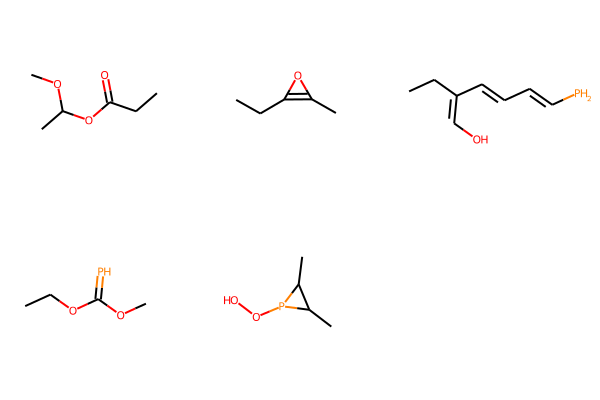

In [17]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

## Approach 2. Molecular design by evolving focused molecular libraries

Let us use MACAW's library evolver to generate molecules with a predicted RON specification of 40. 

By default, `library_evolver` will evolve 8 generations of molecules. This number can be controlled using the optional argument `N_rounds`. With the optional argument `N_hits` we specify the number of molecules that we want the algorithm to return in its output.

In [18]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(smiles, regr, mcw, spec=40., n_hits=5, n_rounds=8)

In [19]:
print(smiles_hits)
print(Y_hits_pred)

['CC1CCC(CCCP)C1', 'CC(CCCCP)CPP', 'CCCCC(C)CC(C)CCCC', 'CCCCPCOCOC', 'CCCCCP=PPC']
[39.93750044 39.99416007 40.01272262 40.05766901 40.06677939]


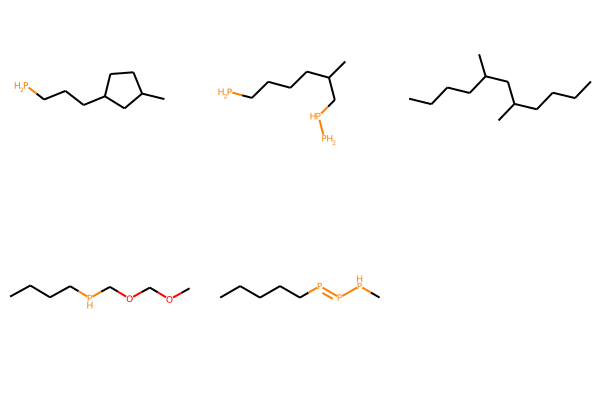

In [20]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

Since we are working with a RVR model, we can also estimate the prediction errors:

In [21]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [22]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)

['CC1CCC(CCCP)C1', 'CC(CCCCP)CPP', 'CCCCC(C)CC(C)CCCC', 'CCCCPCOCOC', 'CCCCCP=PPC']
[39.93750044 39.99416007 40.01272262 40.05766901 40.06677939]
[5.11750141 4.97621519 5.03689286 4.96823964 5.00579259]


Let us now try to design molecules with a RON design specification of 80:

In [23]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(smiles, regr, mcw, spec=80., n_hits=5)

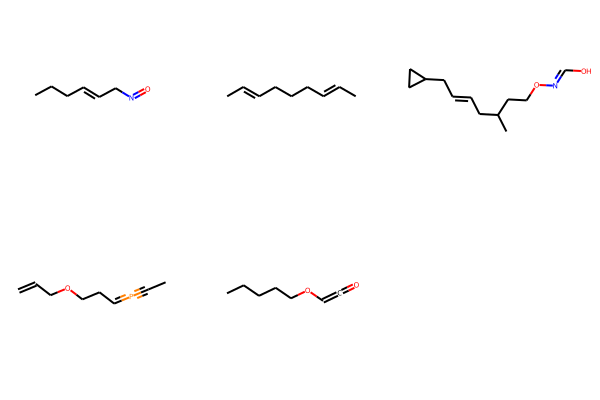

In [24]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

In [25]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [26]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)

['CCCC=CCN=O', 'CC=CCCCC=CC', 'CC(CC=CCC1CC1)CCON=CO', 'C=CCOCCC=P#CC', 'CCCCCOC=C=O']
[79.99617519 79.99698761 79.99975295 80.00044751 80.00368751]
[4.86714384 4.70374604 4.74379376 4.68723048 4.80034113]


Let us now try to design molecules with a RON specification of 120:

In [27]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(smiles, regr, mcw, spec=120., n_hits=5)

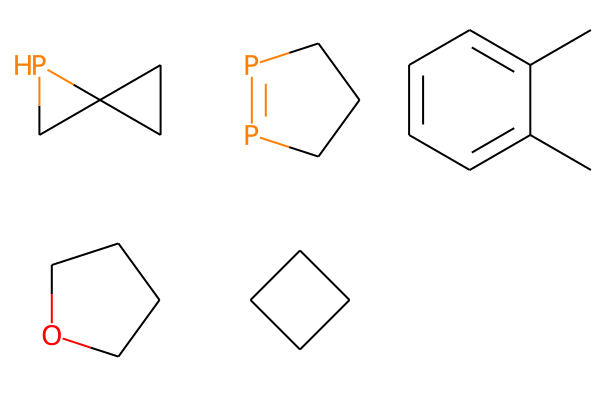

In [28]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

In [29]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [30]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)

['C1CC12CP2', 'C1CP=PC1', 'CC1=CC=CC=C1C', 'C1CCOC1', 'C1CCC1']
[117.23476472 117.4435538  120.75130685 121.26563649 122.38757089]
[6.31023113 6.45839418 6.00204726 6.51395099 7.44988898]


### Multi-objective optimization in molecular recommendation

We can also design molecules aiming to meet several specifications simultaneously. 

In the next example, we will encourage the recommendation of molecules whose property value is predicted with higher confidence and that have a better Synthetic Accessibility (SA) score. The SA score takes values greater than one, with smaller values indicating better synthetic accessibility. 

We define a custome objective function `f`, which returns a weighted sum of 1) the difference from the desired specification (in this case RON = 40.), 2) the prediction uncertainty, and 3) the SA score. Then we ask the `library_evolver` to try to make it zero, which will minimize the objective function.

In [20]:
from rdkit import Chem
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

def SAscore_calc(smi):
    return [sascorer.calculateScore(Chem.MolFromSmiles(s)) for s in smi]

def F(smi, mcw, setpoint):
    X = mcw.transform(smi)
    Y_pred, Y_pred_std = regr.predict(X, return_std=True)
        
    SAScores = SAscore_calc(smi)
    SAScores = np.array(SAScores)
    
    FO = np.abs(Y_pred - setpoint) + 1.*(Y_pred_std) + 2.*SAScores
    return FO

f = lambda smi: F(smi, mcw, setpoint=120.)

Note that since the function `f` directly featurizes the SMILES molecules itself using `mcw`, we do not need the featurizer when calling `library_evolver` (`mcw=None`):

In [21]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(smiles, f, mcw=None, spec=0., n_hits=5, n_rounds=8)

In [22]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [23]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)
print(SAscore_calc(smiles_hits))

['CC1=CC=CC=C1C', 'C1CCOC1', 'C1CCC1', 'C1COC1', 'CCOC(C)=O']
[120.75130685 121.26563649 122.38757089 116.76669887 116.47693969]
[6.00204726 6.51395099 7.44988898 5.93872569 6.00316563]
[1.0337432953498862, 2.0262776130575944, 1.0, 1.5461538156987498, 1.7562997790553911]


The point estimates for the RON of these molecules are not as close to the desired specification as in the design example above, but the prediction errors are smaller and the SA scores are low (close to 1).

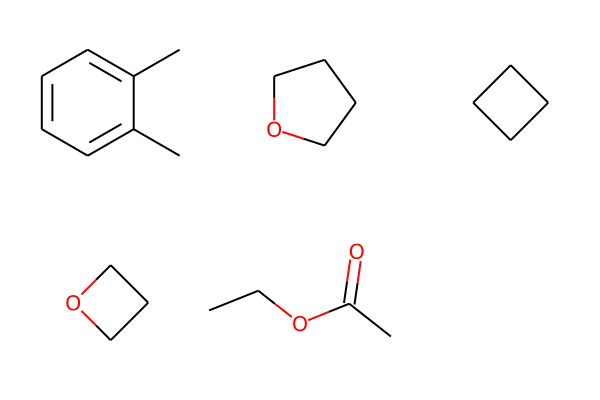

In [24]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)